# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [5]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [6]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


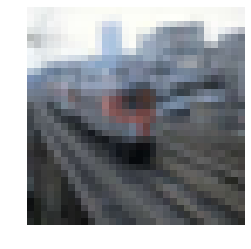

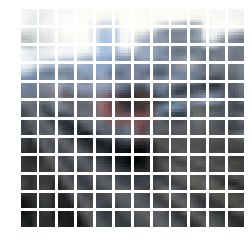

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [8]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [9]:
#@title
# Lint as: python3
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Keras-based attention layer."""

import tensorflow.compat.v2 as tf
# pylint: disable=g-classes-have-attributes

import collections
import math
import string

import numpy as np
from keras import constraints
from keras import initializers
from keras import regularizers
from keras.engine.base_layer import Layer
from keras.layers import advanced_activations
from keras.layers import core
from keras.layers import einsum_dense
from keras.utils import tf_utils
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util.tf_export import keras_export


_CHR_IDX = string.ascii_lowercase


def _build_attention_equation(rank, attn_axes):
  """Builds einsum equations for the attention computation.

  Query, key, value inputs after projection are expected to have the shape as:
  `(bs, <non-attention dims>, <attention dims>, num_heads, channels)`.
  `bs` and `<non-attention dims>` are treated as `<batch dims>`.

  The attention operations can be generalized:
  (1) Query-key dot product:
  `(<batch dims>, <query attention dims>, num_heads, channels), (<batch dims>,
  <key attention dims>, num_heads, channels) -> (<batch dims>,
  num_heads, <query attention dims>, <key attention dims>)`
  (2) Combination:
  `(<batch dims>, num_heads, <query attention dims>, <key attention dims>),
  (<batch dims>, <value attention dims>, num_heads, channels) -> (<batch dims>,
  <query attention dims>, num_heads, channels)`

  Args:
    rank: Rank of query, key, value tensors.
    attn_axes: List/tuple of axes, `[-1, rank)`,
      that attention will be applied to.

  Returns:
    Einsum equations.
  """
  target_notation = _CHR_IDX[:rank]
  # `batch_dims` includes the head dim.
  batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
  letter_offset = rank
  source_notation = ""
  for i in range(rank):
    if i in batch_dims or i == rank - 1:
      source_notation += target_notation[i]
    else:
      source_notation += _CHR_IDX[letter_offset]
      letter_offset += 1

  product_notation = "".join([target_notation[i] for i in batch_dims] +
                             [target_notation[i] for i in attn_axes] +
                             [source_notation[i] for i in attn_axes])
  dot_product_equation = "%s,%s->%s" % (source_notation, target_notation,
                                        product_notation)
  attn_scores_rank = len(product_notation)
  combine_equation = "%s,%s->%s" % (product_notation, source_notation,
                                    target_notation)
  return dot_product_equation, combine_equation, attn_scores_rank


def _build_proj_equation(free_dims, bound_dims, output_dims):
  """Builds an einsum equation for projections inside multi-head attention."""
  input_str = ""
  kernel_str = ""
  output_str = ""
  bias_axes = ""
  letter_offset = 0
  for i in range(free_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    output_str += char

  letter_offset += free_dims
  for i in range(bound_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    kernel_str += char

  letter_offset += bound_dims
  for i in range(output_dims):
    char = _CHR_IDX[i + letter_offset]
    kernel_str += char
    output_str += char
    bias_axes += char
  equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

  return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
  return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)


@keras_export("keras.layers.MultiHeadAttention")
class MultiHeadAttention(Layer):
  """MultiHeadAttention layer.

  This is an implementation of multi-headed attention as described in the paper
  "Attention is all you Need" (Vaswani et al., 2017).
  If `query`, `key,` `value` are the same, then
  this is self-attention. Each timestep in `query` attends to the
  corresponding sequence in `key`, and returns a fixed-width vector.

  This layer first projects `query`, `key` and `value`. These are
  (effectively) a list of tensors of length `num_attention_heads`, where the
  corresponding shapes are `(batch_size, <query dimensions>, key_dim)`,
  `(batch_size, <key/value dimensions>, key_dim)`,
  `(batch_size, <key/value dimensions>, value_dim)`.

  Then, the query and key tensors are dot-producted and scaled. These are
  softmaxed to obtain attention probabilities. The value tensors are then
  interpolated by these probabilities, then concatenated back to a single
  tensor.

  Finally, the result tensor with the last dimension as value_dim can take an
  linear projection and return.

  When using MultiHeadAttention inside a custom Layer, the custom Layer must
  implement `build()` and call MultiHeadAttention's `_build_from_signature()`.
  This enables weights to be restored correctly when the model is loaded.
  TODO(b/172609172): link to documentation about calling custom build functions
  when used in a custom Layer.

  Examples:

  Performs 1D cross-attention over two sequence inputs with an attention mask.
  Returns the additional attention weights over heads.

  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2)
  >>> target = tf.keras.Input(shape=[8, 16])
  >>> source = tf.keras.Input(shape=[4, 16])
  >>> output_tensor, weights = layer(target, source,
  ...                                return_attention_scores=True)
  >>> print(output_tensor.shape)
  (None, 8, 16)
  >>> print(weights.shape)
  (None, 2, 8, 4)

  Performs 2D self-attention over a 5D input tensor on axes 2 and 3.

  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3))
  >>> input_tensor = tf.keras.Input(shape=[5, 3, 4, 16])
  >>> output_tensor = layer(input_tensor, input_tensor)
  >>> print(output_tensor.shape)
  (None, 5, 3, 4, 16)

  Args:
    num_heads: Number of attention heads.
    key_dim: Size of each attention head for query and key.
    value_dim: Size of each attention head for value.
    dropout: Dropout probability.
    use_bias: Boolean, whether the dense layers use bias vectors/matrices.
    output_shape: The expected shape of an output tensor, besides the batch and
      sequence dims. If not specified, projects back to the key feature dim.
    attention_axes: axes over which the attention is applied. `None` means
      attention over all axes, but batch, heads, and features.
    kernel_initializer: Initializer for dense layer kernels.
    bias_initializer: Initializer for dense layer biases.
    kernel_regularizer: Regularizer for dense layer kernels.
    bias_regularizer: Regularizer for dense layer biases.
    activity_regularizer: Regularizer for dense layer activity.
    kernel_constraint: Constraint for dense layer kernels.
    bias_constraint: Constraint for dense layer kernels.

  Call arguments:
    query: Query `Tensor` of shape `(B, T, dim)`.
    value: Value `Tensor` of shape `(B, S, dim)`.
    key: Optional key `Tensor` of shape `(B, S, dim)`. If not given, will use
      `value` for both `key` and `value`, which is the most common case.
    attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
      attention to certain positions. The boolean mask specifies which query
      elements can attend to which key elements, 1 indicates attention and 0
      indicates no attention. Broadcasting can happen for the missing batch
      dimensions and the head dimension.
    return_attention_scores: A boolean to indicate whether the output should
      be `(attention_output, attention_scores)` if `True`, or `attention_output`
      if `False`. Defaults to `False`.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
      Defaults to either using the training mode of the parent layer/model,
      or False (inference) if there is no parent layer.

  Returns:
    attention_output: The result of the computation, of shape `(B, T, E)`,
      where `T` is for target sequence shapes and `E` is the query input last
      dimension if `output_shape` is `None`. Otherwise, the multi-head outputs
      are project to the shape specified by `output_shape`.
    attention_scores: [Optional] multi-head attention coefficients over
      attention axes.
  """

  def __init__(self,
               num_heads,
               key_dim,
               value_dim=None,
               dropout=0.0,
               use_bias=True,
               output_shape=None,
               attention_axes=None,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim if value_dim else key_dim
    self._dropout = dropout
    self._use_bias = use_bias
    self._output_shape = output_shape
    self._kernel_initializer = initializers.get(kernel_initializer)
    self._bias_initializer = initializers.get(bias_initializer)
    self._kernel_regularizer = regularizers.get(kernel_regularizer)
    self._bias_regularizer = regularizers.get(bias_regularizer)
    self._activity_regularizer = regularizers.get(activity_regularizer)
    self._kernel_constraint = constraints.get(kernel_constraint)
    self._bias_constraint = constraints.get(bias_constraint)
    if attention_axes is not None and not isinstance(attention_axes,
                                                     collections.abc.Sized):
      self._attention_axes = (attention_axes,)
    else:
      self._attention_axes = attention_axes
    self._built_from_signature = False
    self._query_shape, self._key_shape, self._value_shape = None, None, None

  def get_config(self):
    config = {
        "num_heads": self._num_heads,
        "key_dim": self._key_dim,
        "value_dim": self._value_dim,
        "dropout": self._dropout,
        "use_bias": self._use_bias,
        "output_shape": self._output_shape,
        "attention_axes": self._attention_axes,
        "kernel_initializer":
            initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            constraints.serialize(self._bias_constraint),
        "query_shape": self._query_shape,
        "key_shape": self._key_shape,
        "value_shape": self._value_shape,
    }
    base_config = super(MultiHeadAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    # If the layer has a different build() function from the Keras default,
    # we need to trigger the customized build to create weights.
    query_shape = config.pop("query_shape")
    key_shape = config.pop("key_shape")
    value_shape = config.pop("value_shape")
    layer = cls(**config)
    if None in [query_shape, key_shape, value_shape]:
      logging.warning(
          "One of dimensions of the input shape is missing. It should have been"
          " memorized when the layer was serialized. "
          "%s is created without weights.",
          str(cls))
    else:
      layer._build_from_signature(query_shape, value_shape, key_shape)  # pylint: disable=protected-access
    return layer

  def _build_from_signature(self, query, value, key=None):
    """Builds layers and variables.

    Once the method is called, self._built_from_signature will be set to True.

    Args:
      query: Query tensor or TensorShape.
      value: Value tensor or TensorShape.
      key: Key tensor or TensorShape.
    """
    self._built_from_signature = True
    if hasattr(query, "shape"):
      self._query_shape = tf.TensorShape(query.shape)
    else:
      self._query_shape = tf.TensorShape(query)
    if hasattr(value, "shape"):
      self._value_shape = tf.TensorShape(value.shape)
    else:
      self._value_shape = tf.TensorShape(value)
    if key is None:
      self._key_shape = self._value_shape
    elif hasattr(key, "shape"):
      self._key_shape = tf.TensorShape(key.shape)
    else:
      self._key_shape = tf.TensorShape(key)

    common_kwargs = dict(
        kernel_initializer=self._kernel_initializer,
        bias_initializer=self._bias_initializer,
        kernel_regularizer=self._kernel_regularizer,
        bias_regularizer=self._bias_regularizer,
        activity_regularizer=self._activity_regularizer,
        kernel_constraint=self._kernel_constraint,
        bias_constraint=self._bias_constraint)
    # Any setup work performed only once should happen in an `init_scope`
    # to avoid creating symbolic Tensors that will later pollute any eager
    # operations.
    with tf_utils.maybe_init_scope(self):
      free_dims = self._query_shape.rank - 1
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=1, output_dims=2)
      self._query_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="query",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          self._key_shape.rank - 1, bound_dims=1, output_dims=2)
      self._key_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="key",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          self._value_shape.rank - 1, bound_dims=1, output_dims=2)
      self._value_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._value_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="value",
          **common_kwargs)

      # Builds the attention computations for multi-head dot product attention.
      # These computations could be wrapped into the keras attention layer once
      # it support mult-head einsum computations.
      self._build_attention(output_rank)
      self._output_dense = self._make_output_dense(
          free_dims, common_kwargs, "attention_output")

  def _make_output_dense(self, free_dims, common_kwargs, name=None):
    """Builds the output projection matrix.

    Args:
      free_dims: Number of free dimensions for einsum equation building.
      common_kwargs: Common keyword arguments for einsum layer.
      name: Name for the projection layer.

    Returns:
      Projection layer.
    """
    if self._output_shape:
      if not isinstance(self._output_shape, collections.abc.Sized):
        output_shape = [self._output_shape]
      else:
        output_shape = self._output_shape
    else:
      output_shape = [self._query_shape[-1]]
    einsum_equation, bias_axes, output_rank = _build_proj_equation(
        free_dims, bound_dims=2, output_dims=len(output_shape))
    return einsum_dense.EinsumDense(
        einsum_equation,
        output_shape=_get_output_shape(output_rank - 1, output_shape),
        bias_axes=bias_axes if self._use_bias else None,
        name=name,
        **common_kwargs)

  def _build_attention(self, rank):
    """Builds multi-head dot-product attention computations.

    This function builds attributes necessary for `_compute_attention` to
    costomize attention computation to replace the default dot-product
    attention.

    Args:
      rank: the rank of query, key, value tensors.
    """
    if self._attention_axes is None:
      self._attention_axes = tuple(range(1, rank - 2))
    else:
      self._attention_axes = tuple(self._attention_axes)
    self._dot_product_equation, self._combine_equation, attn_scores_rank = (
        _build_attention_equation(rank, attn_axes=self._attention_axes))
    norm_axes = tuple(
        range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
    self._softmax = advanced_activations.Softmax(axis=norm_axes)
    self._dropout_layer = core.Dropout(rate=self._dropout)

  def _masked_softmax(self, attention_scores, attention_mask=None):
    # Normalize the attention scores to probabilities.
    # `attention_scores` = [B, N, T, S]
    if attention_mask is not None:
      # The expand dim happens starting from the `num_heads` dimension,
      # (<batch_dims>, num_heads, <query_attention_dims, key_attention_dims>)
      mask_expansion_axis = -len(self._attention_axes) * 2 - 1
      for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
        attention_mask = tf.expand_dims(
            attention_mask, axis=mask_expansion_axis)
    return self._softmax(attention_scores, attention_mask)

  def _compute_attention(self,
                         query,
                         key,
                         value,
                         attention_mask=None,
                         training=None):
    """Applies Dot-product attention with query, key, value tensors.

    This function defines the computation inside `call` with projected
    multi-head Q, K, V inputs. Users can override this function for customized
    attention implementation.

    Args:
      query: Projected query `Tensor` of shape `(B, T, N, key_dim)`.
      key: Projected key `Tensor` of shape `(B, T, N, key_dim)`.
      value: Projected value `Tensor` of shape `(B, T, N, value_dim)`.
      attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
        attention to certain positions.
      training: Python boolean indicating whether the layer should behave in
        training mode (adding dropout) or in inference mode (doing nothing).

    Returns:
      attention_output: Multi-headed outputs of attention computation.
      attention_scores: Multi-headed attention weights.
    """
    # Note: Applying scalar multiply at the smaller end of einsum improves
    # XLA performance, but may introduce slight numeric differences in
    # the Transformer attention head.
    query = tf.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

    # Take the dot product between "query" and "key" to get the raw
    # attention scores.
    attention_scores = tf.einsum(self._dot_product_equation, key,
                                               query)

    attention_scores = self._masked_softmax(attention_scores, attention_mask)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_scores_dropout = self._dropout_layer(
        attention_scores, training=training)

    # `context_layer` = [B, T, N, H]
    attention_output = tf.einsum(self._combine_equation,
                                               attention_scores_dropout, value)
    return attention_output, attention_scores

  def call(self,
           query,
           value,
           key=None,
           attention_mask=None,
           return_attention_scores=False,
           training=None):
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      key = value

    #   N = `num_attention_heads`
    #   H = `size_per_head`
    # `query` = [B, T, N ,H]
    query = self._query_dense(query)

    # `key` = [B, S, N, H]
    key = self._key_dense(key)

    # `value` = [B, S, N, H]
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output


In [10]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [11]:
create_vit_classifier().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 144, 128)     8320        ['layer_normalization_7[0][0]']  
          

                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 144, 64)     66368       ['layer_normalization_14[0][0]', 
 eadAttent

In [12]:
create_vit_classifier().count_params()

21759019

In [13]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
352/352 [==============================] - 68s 162ms/step - loss: 4.4752 - accuracy: 0.0425 - top-5-accuracy: 0.1544 - val_loss: 3.9196 - val_accuracy: 0.1026 - val_top-5-accuracy: 0.3050
Epoch 2/100
352/352 [==============================] - 56s 160ms/step - loss: 3.9654 - accuracy: 0.0912 - top-5-accuracy: 0.2812 - val_loss: 3.6076 - val_accuracy: 0.1476 - val_top-5-accuracy: 0.3978
Epoch 3/100
352/352 [==============================] - 56s 159ms/step - loss: 3.7036 - accuracy: 0.1260 - top-5-accuracy: 0.3608 - val_loss: 3.3588 - val_accuracy: 0.2000 - val_top-5-accuracy: 0.4634
Epoch 4/100
352/352 [==============================] - 56s 160ms/step - loss: 3.5030 - accuracy: 0.1596 - top-5-accuracy: 0.4218 - val_loss: 3.1764 - val_accuracy: 0.2174 - val_top-5-accuracy: 0.5124
Epoch 5/100
352/352 [==============================] - 56s 160ms/step - loss: 3.3051 - accuracy: 0.1970 - top-5-accuracy: 0.4766 - val_loss: 2.9899 - val_accuracy: 0.2570 - val_top-5-accuracy: 0.5476


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



352/352 [==============================] - 55s 157ms/step - loss: 1.5007 - accuracy: 0.5775 - top-5-accuracy: 0.8647 - val_loss: 1.9136 - val_accuracy: 0.5060 - val_top-5-accuracy: 0.7830
Epoch 42/100
352/352 [==============================] - 55s 157ms/step - loss: 1.4492 - accuracy: 0.5913 - top-5-accuracy: 0.8737 - val_loss: 1.9248 - val_accuracy: 0.5058 - val_top-5-accuracy: 0.7852
Epoch 45/100
352/352 [==============================] - 55s 156ms/step - loss: 1.4451 - accuracy: 0.5909 - top-5-accuracy: 0.8740 - val_loss: 1.9325 - val_accuracy: 0.5066 - val_top-5-accuracy: 0.7858
Epoch 46/100
352/352 [==============================] - 55s 156ms/step - loss: 1.4203 - accuracy: 0.5988 - top-5-accuracy: 0.8779 - val_loss: 1.9211 - val_accuracy: 0.5096 - val_top-5-accuracy: 0.7870
Epoch 47/100
352/352 [==============================] - 56s 159ms/step - loss: 1.4113 - accuracy: 0.5961 - top-5-accuracy: 0.8813 - val_loss: 1.9063 - val_accuracy: 0.5116 - val_top-5-accuracy: 0.7864
Epoch 48

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



352/352 [==============================] - 69s 196ms/step - loss: 1.1438 - accuracy: 0.6695 - top-5-accuracy: 0.9201 - val_loss: 1.8508 - val_accuracy: 0.5286 - val_top-5-accuracy: 0.8064
Epoch 80/100
352/352 [==============================] - 67s 192ms/step - loss: 1.1277 - accuracy: 0.6702 - top-5-accuracy: 0.9215 - val_loss: 1.8612 - val_accuracy: 0.5350 - val_top-5-accuracy: 0.8094
Epoch 81/100
352/352 [==============================] - 69s 196ms/step - loss: 1.1144 - accuracy: 0.6765 - top-5-accuracy: 0.9226 - val_loss: 1.8980 - val_accuracy: 0.5312 - val_top-5-accuracy: 0.8022
Epoch 82/100
352/352 [==============================] - 68s 194ms/step - loss: 1.1195 - accuracy: 0.6756 - top-5-accuracy: 0.9223 - val_loss: 1.8812 - val_accuracy: 0.5272 - val_top-5-accuracy: 0.8022
Epoch 83/100
352/352 [==============================] - 67s 190ms/step - loss: 1.1248 - accuracy: 0.6732 - top-5-accuracy: 0.9208 - val_loss: 1.8882 - val_accuracy: 0.5302 - val_top-5-accuracy: 0.8006
Epoch 84

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.